# Оптимизация управления персоналом для HR сервиса.


## Пакеты и импорты

In [5]:
!pip install phik -q
!pip install scikit-learn==0.24.1 -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for scikit-learn (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for scikit-learn
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (scikit-learn)


In [6]:
# Импорты
import shap
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.svm import SVC, SVR
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score, make_scorer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.preprocessing import (
     OneHotEncoder,
     OrdinalEncoder,
     StandardScaler,
     RobustScaler,
     MinMaxScaler,
     OrdinalEncoder)
from sklearn.model_selection import (
     RandomizedSearchCV,
     train_test_split)

from phik import phik_matrix
from phik.report import plot_correlation_matrix

In [7]:
RANDOM_STATE = 52

# Оценка индекса удволетворённости сотрудников

**Создание модели регрессии, предсказывающей значение целевого признака 'job_satisfaction_rate'**

`Целевая метрика - SMAPE <= 15`

## Загрузка и первичный анализ данных

In [8]:
df_train = pd.read_csv('train_job_satisfaction_rate.csv')

In [9]:
df_test1 =  pd.read_csv('test_features.csv')
df_test2 =  pd.read_csv('test_target_job_satisfaction_rate.csv')

In [10]:
df_test1.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [11]:
df_test2.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [12]:
df_test = df_test1.merge(df_test2, how='left', on='id')

In [13]:
df_test

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75
...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.56
1996,109582,technology,middle,low,3,no,no,2,21600,0.14
1997,305653,technology,junior,low,1,no,no,3,14400,0.11
1998,160233,technology,middle,low,8,no,no,1,32400,0.43


In [14]:
df_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [16]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 156.4+ KB


### Вывод

**В данных есть отсутствующие значения, создали df_test с входным и целевым признаками для тестирования модели.**

## Предобработка

In [17]:
df_train = df_train.set_index('id')
df_test = df_test.set_index('id')

In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 485046 to 771859
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   1998 non-null   object 
 1   level                  1999 non-null   object 
 2   workload               2000 non-null   object 
 3   employment_years       2000 non-null   int64  
 4   last_year_promo        2000 non-null   object 
 5   last_year_violations   2000 non-null   object 
 6   supervisor_evaluation  2000 non-null   int64  
 7   salary                 2000 non-null   int64  
 8   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 156.2+ KB


In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


In [20]:
# Явные дубликаты
df_train.duplicated().sum()

np.int64(245)

In [21]:
df_test.duplicated().sum()

np.int64(83)

In [22]:
df_train = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()

In [23]:
# Неявные дубликаты
for i in df_train.select_dtypes(include = 'object').columns:
        print(f'уникальные значения столбца {i} : {df_train[i].unique()}')

уникальные значения столбца dept : ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
уникальные значения столбца level : ['junior' 'middle' 'sinior' nan]
уникальные значения столбца workload : ['medium' 'high' 'low']
уникальные значения столбца last_year_promo : ['no' 'yes']
уникальные значения столбца last_year_violations : ['no' 'yes']


In [24]:
for i in df_test.select_dtypes(include = 'object').columns:
        print(f'уникальные значения столбца {i} : {df_train[i].unique()}')

уникальные значения столбца dept : ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
уникальные значения столбца level : ['junior' 'middle' 'sinior' nan]
уникальные значения столбца workload : ['medium' 'high' 'low']
уникальные значения столбца last_year_promo : ['no' 'yes']
уникальные значения столбца last_year_violations : ['no' 'yes']


### Вывод:

**Дубликаты удалены, Nan заменим с помошью SimpleImputer в пайплайне.**

## Исследовательский анализ

### Численные признаки

In [76]:
# Автоматизируем изучение кол. признаков

def numgraph(col):
  if col.dtype in ['int64', 'float']:
    fig, axs = plt.subplots(1,2,figsize=(15, 5))
    fig.suptitle(f'{str(col.name)}: hist and boxplot')

    sns.histplot(col, bins=10, ax=axs[0])
    axs[0].axvline(col.mean(), color='r')
    axs[0].axvline(col.median(), color='r', linestyle='dashed')

    sns.boxplot(x=col, ax=axs[1])

    plt.show()
    print(col.describe())

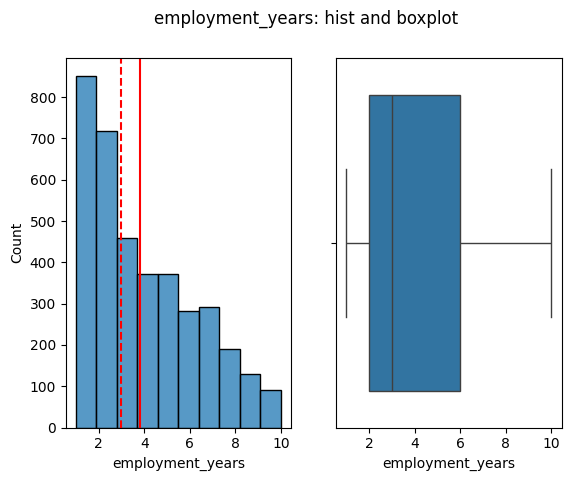

count    3755.000000
mean        3.817044
std         2.557142
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


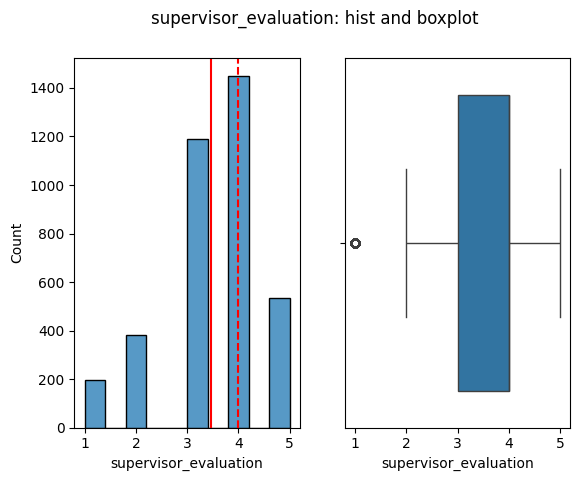

count    3755.000000
mean        3.463648
std         1.026265
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


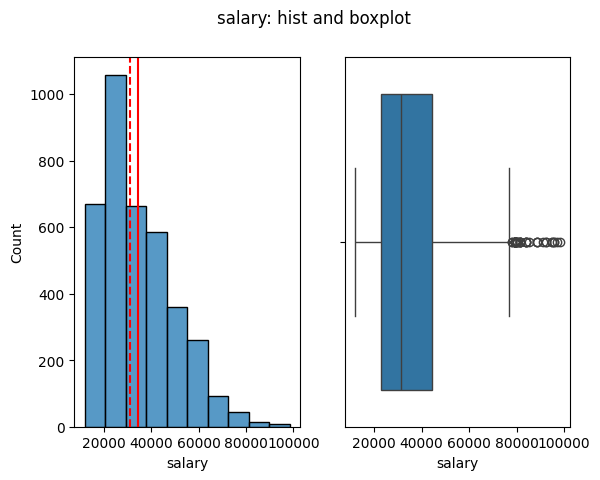

count     3755.000000
mean     34457.416778
std      15050.643870
min      12000.000000
25%      22800.000000
50%      31200.000000
75%      44400.000000
max      98400.000000
Name: salary, dtype: float64


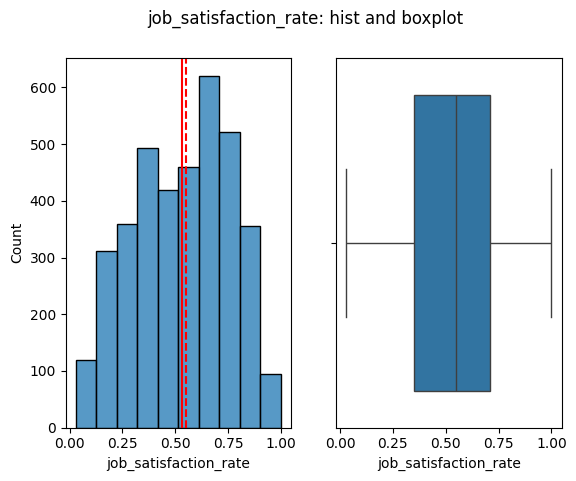

count    3755.000000
mean        0.532554
std         0.226393
min         0.030000
25%         0.350000
50%         0.550000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


In [26]:
for i in df_train.columns:
    numgraph(df_train[i])

Большинство значений близки к нормальному распределению,
однако наблюдается правый "хвост" из высокооплачиваемых сотрудников. Распределение по стажу работы в компании(employment years) смещено к более "молодым" сотрудникам.

### Категориальные признаки

In [27]:
# Автоматизируем изучение кат. признаков


def catgraph(df, col):
    dfg = df.groupby(col.name).size()
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    axs[0].pie(dfg, labels=dfg.index, autopct='%1.1f%%')
    axs[0].set_title(f'Pie Chart {col.name}')
    axs[1].bar(dfg.index, dfg)
    axs[1].set_title(f'Bar Chart {col.name}')
    plt.show

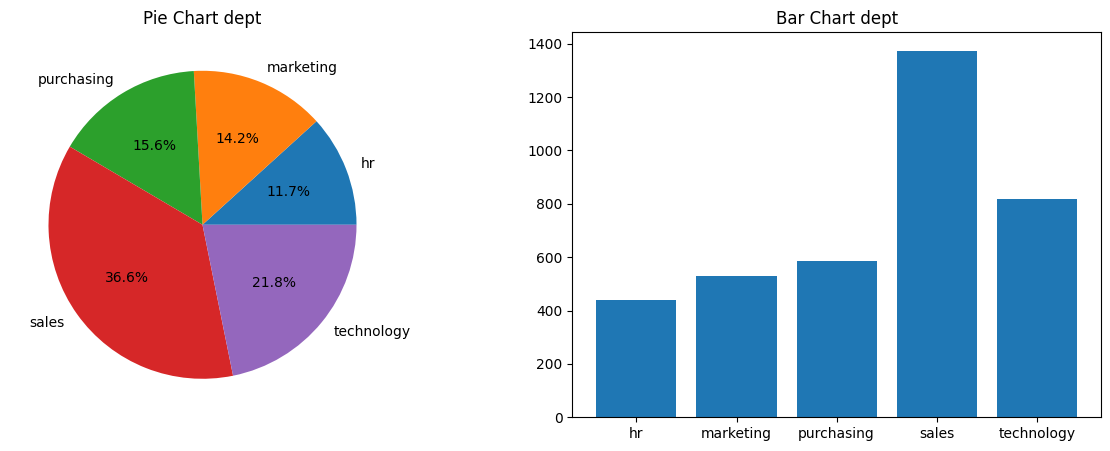

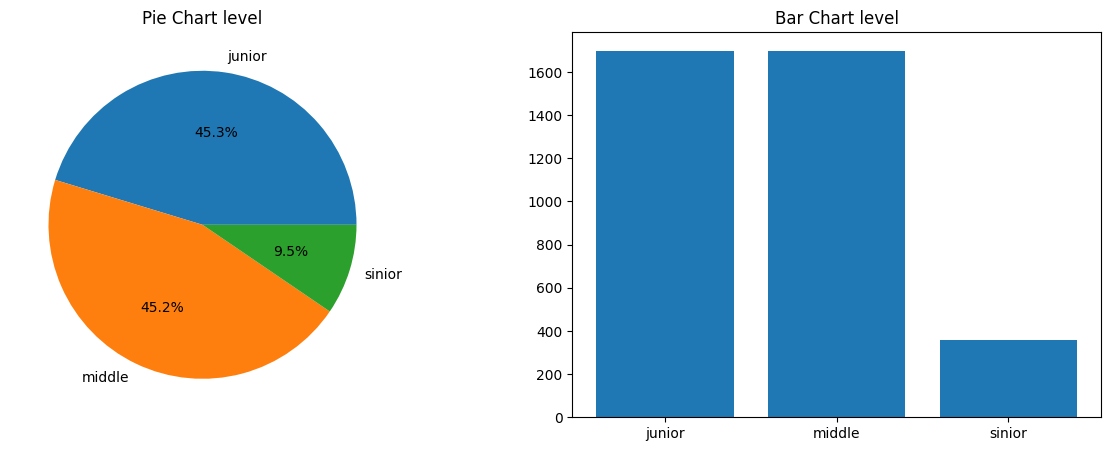

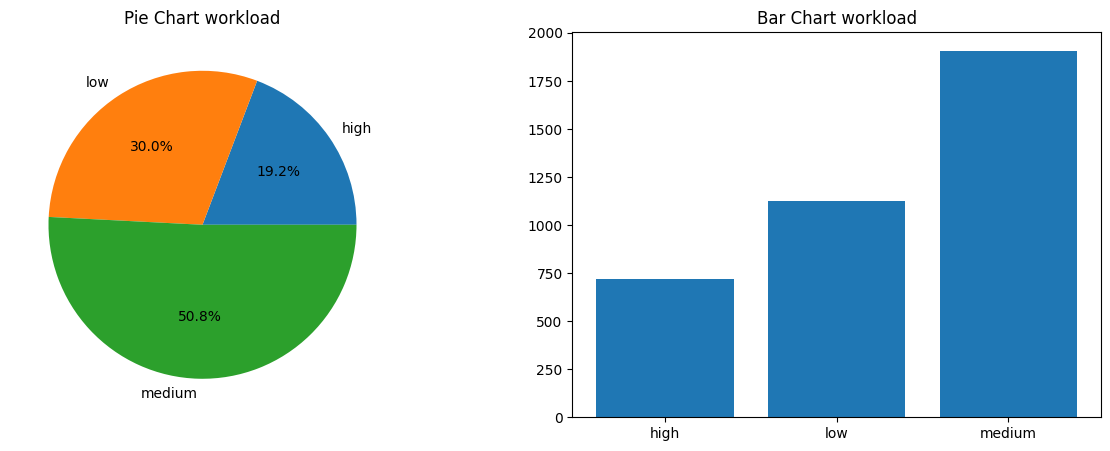

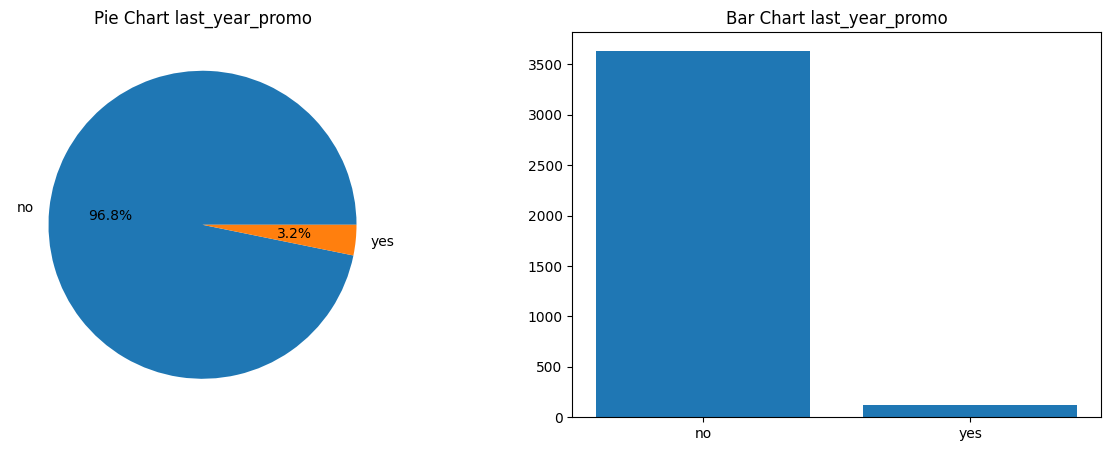

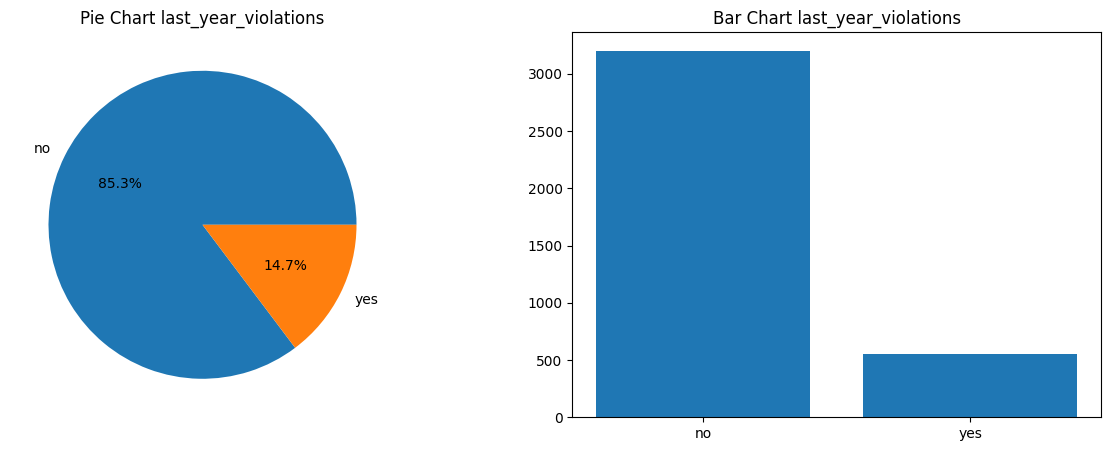

In [28]:
for i in df_train.select_dtypes(include = 'object').columns:
        catgraph(df_train, df_train[i])

### Вывод:

Категориальные признаки распределены равномерно.


## Корреляционный анализ


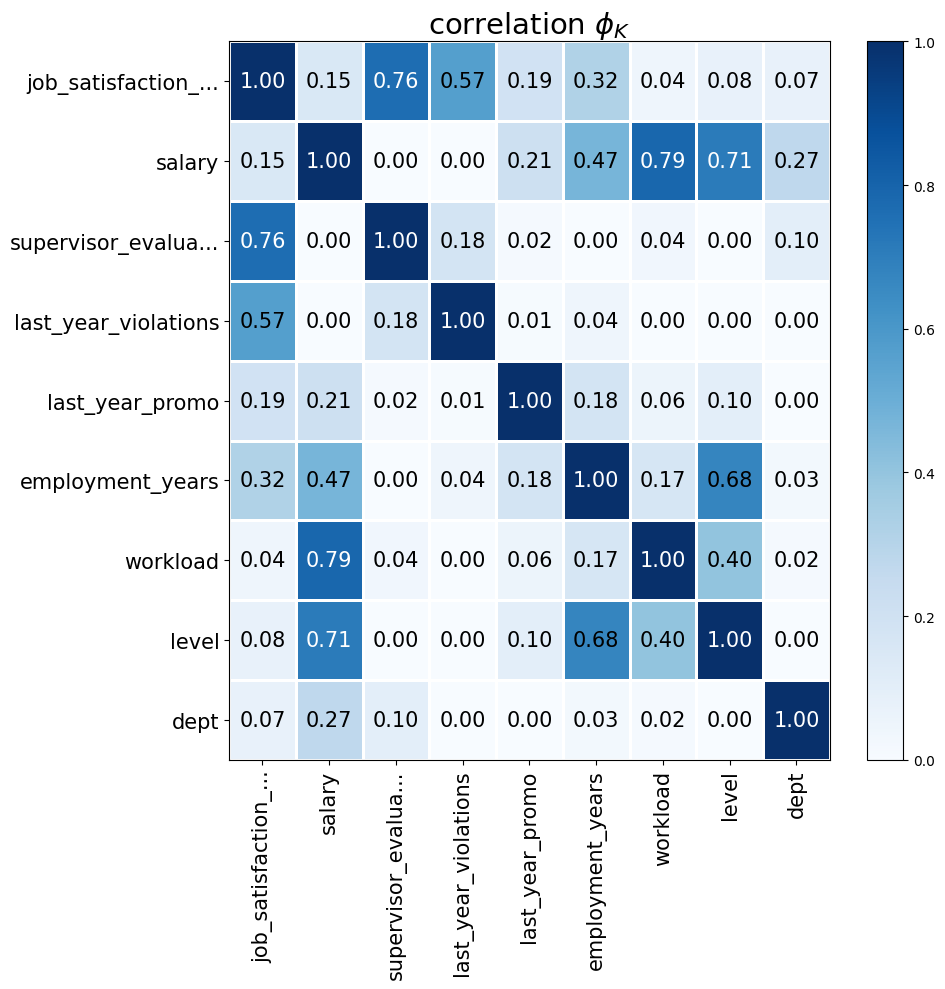

In [30]:
# Матрица phik

interval_cols = df_train.select_dtypes(exclude = 'object').columns
phik_overview = phik_matrix(df_train, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(10, 10)
)

**Сильные зависимости:**

workload ↔ salary — φₖ ≈ 0.79 (вполне понятная зависимость загрузки и зп, но рассмотреть подробнее стоит);

level ↔ salary — φₖ ≈ 0.71 (тоже очевидно);

supervisor_evaluation ↔ job_satisfaction_rate — φₖ ≈ 0.76 (тут интересно, посмотрим дальше природу зависимости);

level ↔ employment_years — φₖ ≈ 0.68 (вполне понятно, интересно было бы сделать новый признак, отражающий расхождение в сроке работы в компании и позиции).

### workload ↔ salary

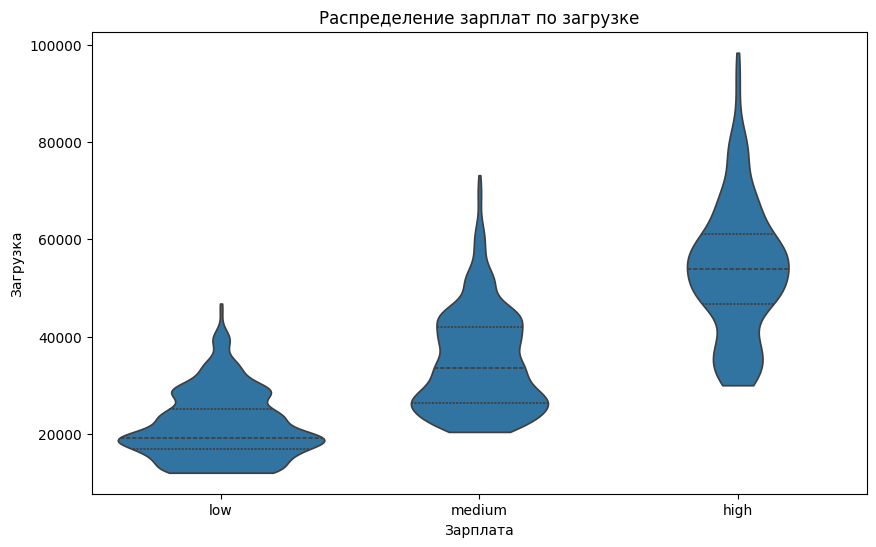

In [31]:
plt.figure(figsize=(10, 6))

order = ['low', 'medium', 'high']

sns.violinplot(
    data=df_train,
    x="workload",
    y="salary",
    order=order,
    inner="quartile",
    cut=0
)

plt.title("Распределение зарплат по загрузке")
plt.xlabel("Зарплата")
plt.ylabel("Загрузка")

plt.show()

Картина естественная, как работал – так и заработал.

### level ↔ salary

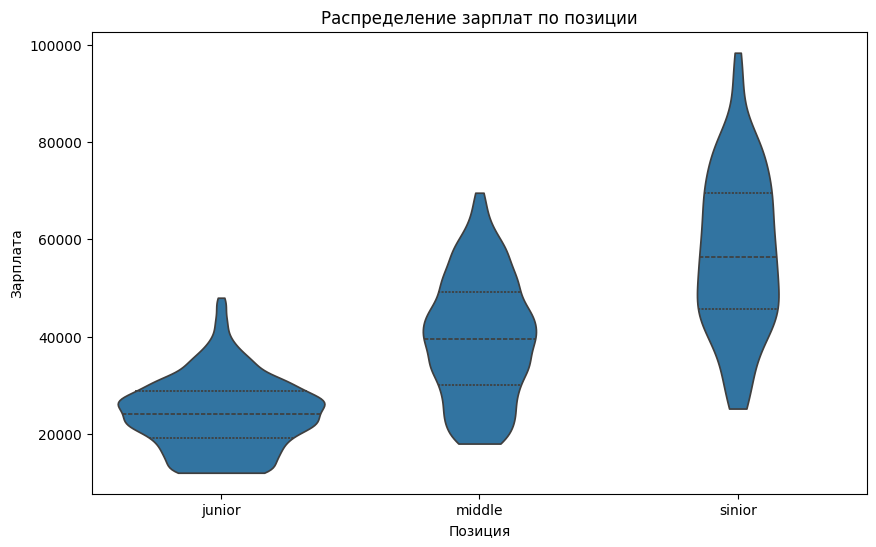

In [32]:
plt.figure(figsize=(10, 6))

sns.violinplot(
    data=df_train,
    x="level",
    y="salary",
    inner="quartile",
    cut=0
)

plt.title("Распределение зарплат по позиции")
plt.xlabel("Позиция")
plt.ylabel("Зарплата")

plt.show()

Картина естественная: старшие позиции зарабатывают больше младших.

### supervisor_evaluation ↔ job_satisfaction_rate

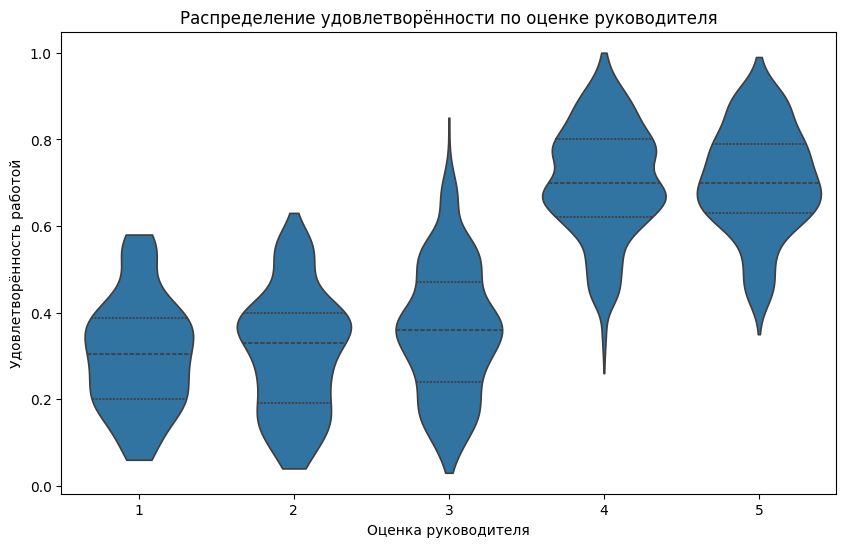

In [33]:
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_train,
    x='supervisor_evaluation',
    y='job_satisfaction_rate',
    inner='quartile',
    cut=0
)
plt.title("Распределение удовлетворённости по оценке руководителя")
plt.xlabel("Оценка руководителя")
plt.ylabel("Удовлетворённость работой")
plt.show()

Картина близкая к линейной зависимости, полезный для модели признак.

### level ↔ employment_years

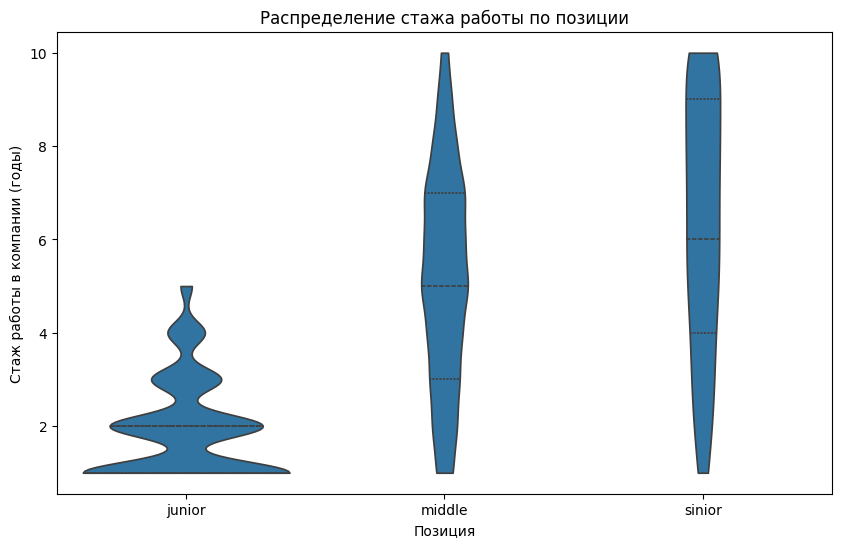

In [34]:
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_train,
    x='level',
    y='employment_years',
    inner='quartile',
    cut=0
)
plt.title("Распределение стажа работы по позиции")
plt.xlabel("Позиция")
plt.ylabel("Стаж работы в компании (годы)")
plt.show()

Общаяя картина:

 - Джуны в большинстве своем "молодые" – хорошо;
 - Сениоры распределены ровно, чуть больше на высоких стажах, что тоже ок;
 - Есть немало мидлов, остающихся на позиции 6+ лет, что, потенциально, может быть причиной увольнения.

Гипотеза:

Заметно, что "конус" на графике джуниор позиции сужается с ростом стажа, это значит что джун либо уходит на мидл позицию, либо уходит из компании. При этом в том же диапазоне (0-5 лет) мы видим плавный рост количаства мидлов, однако количество джуниор специалистов снижается быстрее, чем растет количество мидлов. Предположение: работники уходят, не дождавшись получения мидл позиции.

### Вывод
Перед обучением линейной модели избавимся от мультиколлениарности, выведена гипотеза об уходе джуниор специалистов.

## Подготовка данных

In [35]:
df_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [36]:
X_train = df_train.drop('job_satisfaction_rate', axis = 1)
y_train = df_train['job_satisfaction_rate']

In [37]:
ord_cols = ['level','workload']
ohe_cols = ['dept', 'last_year_promo', 'last_year_violations']
num_cols = df_train.select_dtypes(exclude = 'object').columns.drop('job_satisfaction_rate')

In [38]:
ohe_pipe = Pipeline(
[
    ('SimpleImputer_ohe',
    SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('SimpleImputer_2',
    SimpleImputer(missing_values= ' ', strategy='most_frequent')),
    ('ohe',
    OneHotEncoder(drop = 'first', handle_unknown='error'))
]
)

ord_pipe = Pipeline(
[
    ('SimpleImputer_bOE',
    SimpleImputer(missing_values = np.nan, strategy ='most_frequent')),
    ('OE',
    OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = np.nan)),
    ('SimpleImputer_aOE',
    SimpleImputer(missing_values = np.nan, strategy ='most_frequent'))
]
)

preprocessor = ColumnTransformer(
[
    ('ohe', ohe_pipe, ohe_cols),
    ('ord', ord_pipe, ord_cols),
    ('num', StandardScaler(), num_cols)
],
    remainder='passthrough'
)

In [39]:
param_grid = [
    {
       'model' : [SVR()],
       'model__kernel' : ['poly', 'rbf', 'sigmoid', 'precomputed'],
       'model__degree' : range(1,4),
       'preprocessor__num' : [StandardScaler(),
                           MinMaxScaler(),
                           RobustScaler(),
                           'passthrough']
    },

    {
        'model' : [GradientBoostingRegressor()],
        'model__n_estimators' : range(100, 300, 10),
        'model__max_depth' : range(1,30),
        'model__min_samples_split' : range(2,30),
        'model__min_samples_leaf' : range(1,30),
        'preprocessor__num' : [StandardScaler(),
                           MinMaxScaler(),
                           RobustScaler(),
                           'passthrough']
    },
    {
        'model' : [DecisionTreeRegressor(random_state = RANDOM_STATE)],
        'model__max_depth' : range(1,30),
        'model__min_samples_split' : range(2,30),
        'model__min_samples_leaf' : range(1,30),
        'preprocessor__num' : [StandardScaler(),
                           MinMaxScaler(),
                           RobustScaler(),
                           'passthrough']
    }
]

In [40]:
full_pipe = Pipeline(
[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
]
)

In [41]:
def smape(A, F):
    return 100/abs(len(A)) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
smape_scorer = make_scorer(smape, greater_is_better=False)

In [42]:
randomized_search = RandomizedSearchCV(
    full_pipe,
    param_distributions=param_grid,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

## Обучение моделей

In [43]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('SimpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('SimpleImputer_2',
                                                                                                SimpleImputer(missing_values=' ',
                                                                                                              strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_...
                                                               'passthrough']},
                                        {'model': [DecisionTreeRegressor(random_state=52)],
                                         'model__max_depth': range(1, 30),
                                         'model__min_samples_leaf': range(1, 30),
                                         'model__min_samples_split': range(2, 30),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=52,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [44]:
model = randomized_search.best_estimator_

In [45]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('SimpleImputer_2',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pip...
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('SimpleImputer_aOE',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', 'passthrough',
                                                  Index(['employment_years', 'supervisor_evaluation', 'salary'], dtype='object'))])),
                ('model',
                 GradientBoostingRegressor(max_depth=16, min_samples_leaf=24,
                                           min_samples_split=12,
                                           n_estimators=240))])

In [46]:
randomized_search.best_score_

np.float64(-12.092586284316647)

In [47]:
y_pred = model.predict(df_test.drop('job_satisfaction_rate', axis = 1))
smape(df_test['job_satisfaction_rate'], y_pred)

np.float64(11.264977208046083)

### Вывод

Лучше всего себя показал градиентный бустинг. SMAPE 11.27

# Предсказание ухода сотрудника из компании
Создание модели классификации

`Целевая метрика ROC-AUC >=91`

## Загрузка данных

In [48]:
df_train = pd.read_csv('train_quit.csv').set_index('id')

In [49]:
df_test1 = pd.read_csv('test_target_quit.csv').set_index('id')

In [50]:
df_test = df_test.join(df_test1, how = 'inner')

In [51]:
df_test

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
686555,hr,junior,medium,1,no,no,4,30000,0.72,no
467458,sales,middle,low,5,no,no,4,19200,0.64,no
418655,sales,middle,low,6,no,no,4,19200,0.60,no
789145,hr,middle,medium,5,no,no,5,40800,0.75,no
...,...,...,...,...,...,...,...,...,...,...
497976,technology,middle,medium,3,no,no,4,52800,0.70,no
393147,marketing,junior,low,3,no,no,3,20400,0.56,yes
109582,technology,middle,low,3,no,no,2,21600,0.14,yes


In [52]:
df_train

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no
...,...,...,...,...,...,...,...,...,...
588809,sales,junior,medium,4,no,no,3,26400,no
672059,sales,middle,high,9,no,no,4,52800,no
536432,purchasing,junior,low,2,no,yes,4,12000,yes


In [53]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB


In [54]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1917 entries, 485046 to 771859
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   1915 non-null   object 
 1   level                  1916 non-null   object 
 2   workload               1917 non-null   object 
 3   employment_years       1917 non-null   int64  
 4   last_year_promo        1917 non-null   object 
 5   last_year_violations   1917 non-null   object 
 6   supervisor_evaluation  1917 non-null   int64  
 7   salary                 1917 non-null   int64  
 8   job_satisfaction_rate  1917 non-null   float64
 9   quit                   1917 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 164.7+ KB


### Вывод

В данных есть Nan, для удобства создана таблица df_test с входным и целевым признаками для тестирования модели. Стандартизация имён столлбцов не требуется.

### Предобработка

In [55]:
df_train.duplicated().sum()

np.int64(1413)

In [56]:
df_test.duplicated().sum()

np.int64(0)

In [57]:
df_train = df_train.drop_duplicates()

### Вывод

**Дубликаты удалены, Nan будут удалены позже в пайплайне.**

## Исследовательский анализ

### Численные признаки

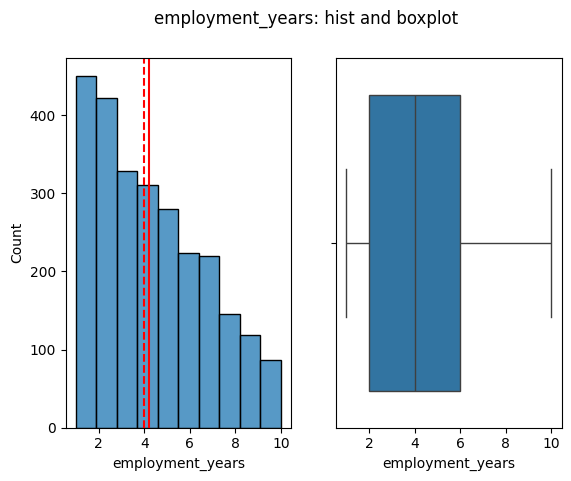

count    2587.000000
mean        4.213375
std         2.601105
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


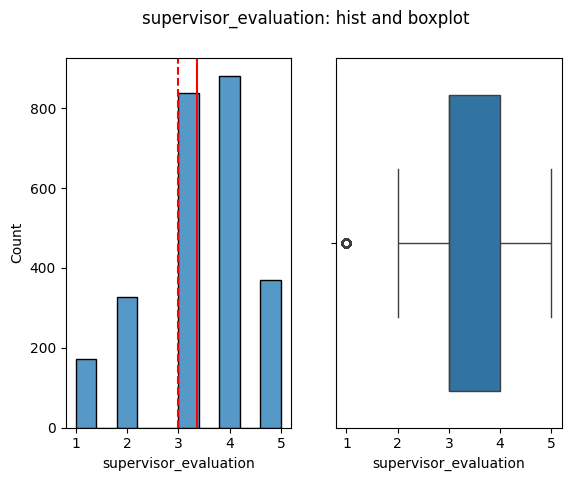

count    2587.000000
mean        3.367994
std         1.080243
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


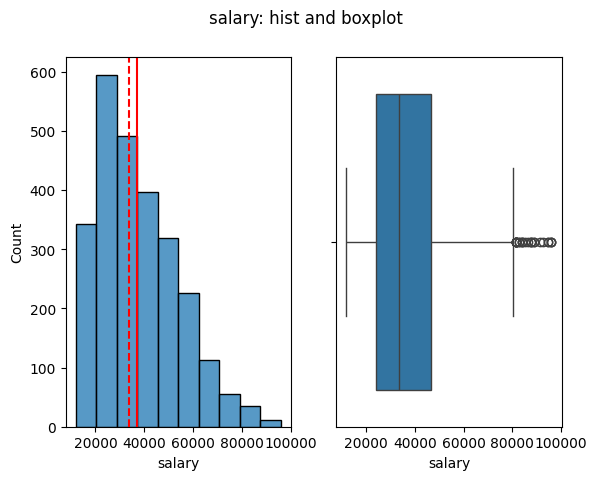

count     2587.000000
mean     37107.692308
std      16267.354906
min      12000.000000
25%      24000.000000
50%      33600.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64


In [58]:
for i in df_train.columns:
    numgraph(df_train[i])

В основном, признаки распределены ненормально, для корреляционного анализа снова будем использовать phik.

### Категориальные признаки

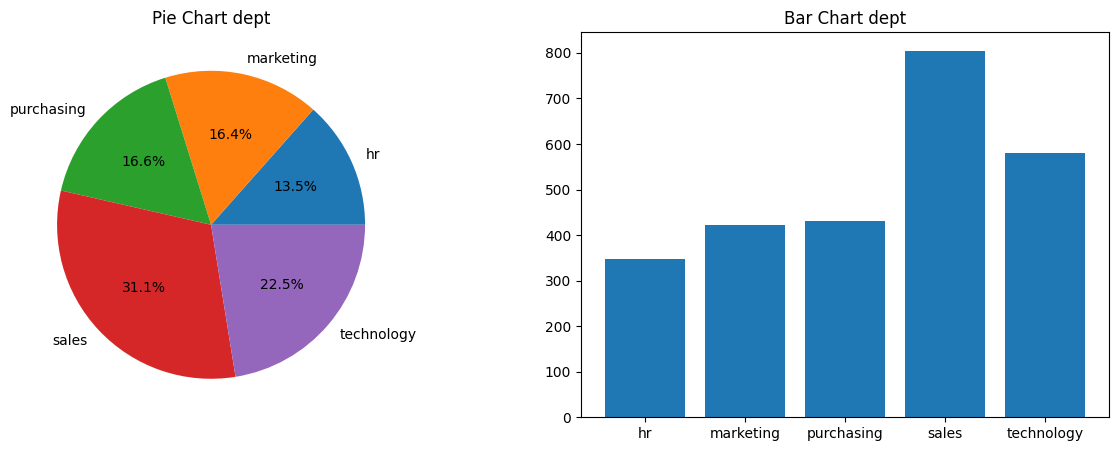

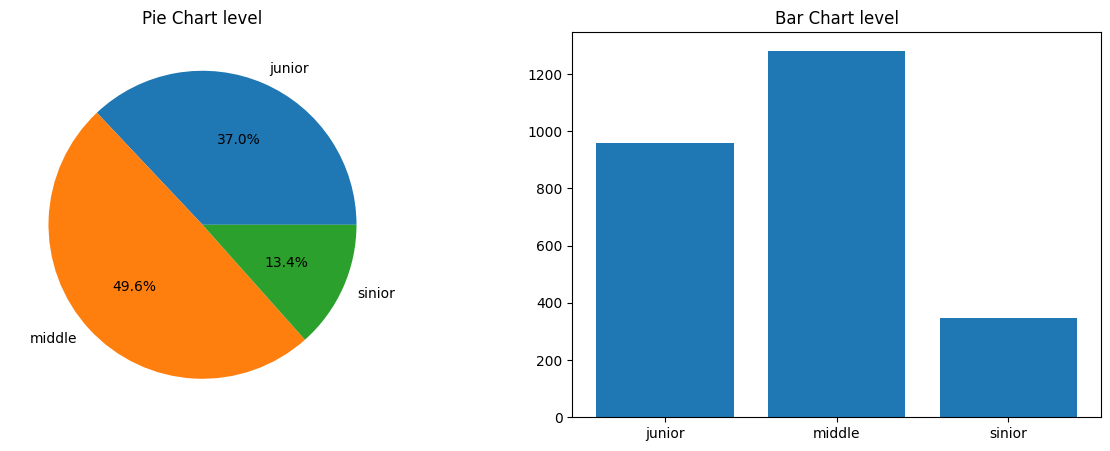

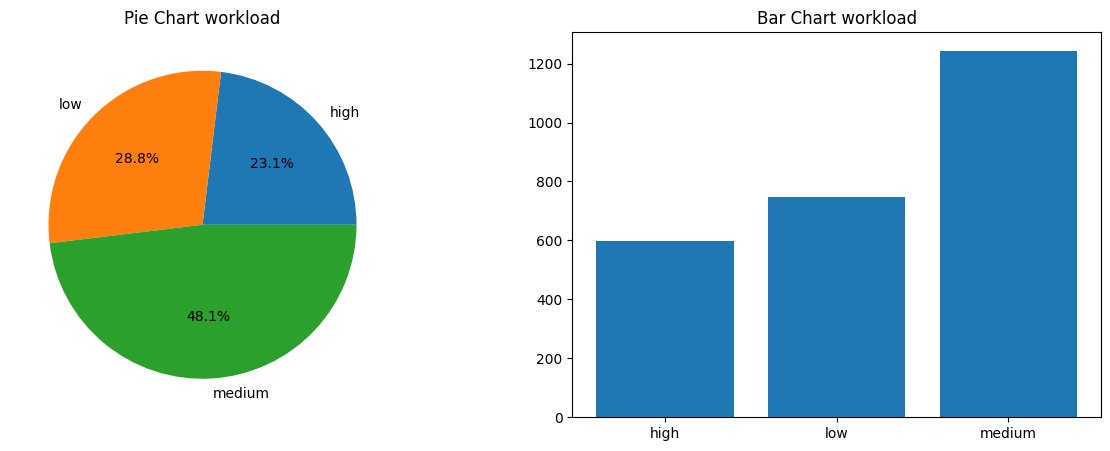

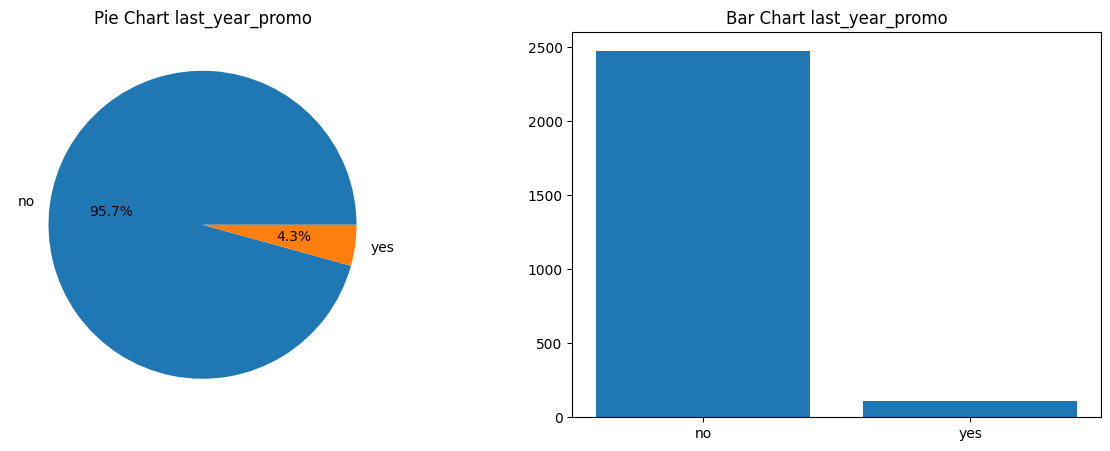

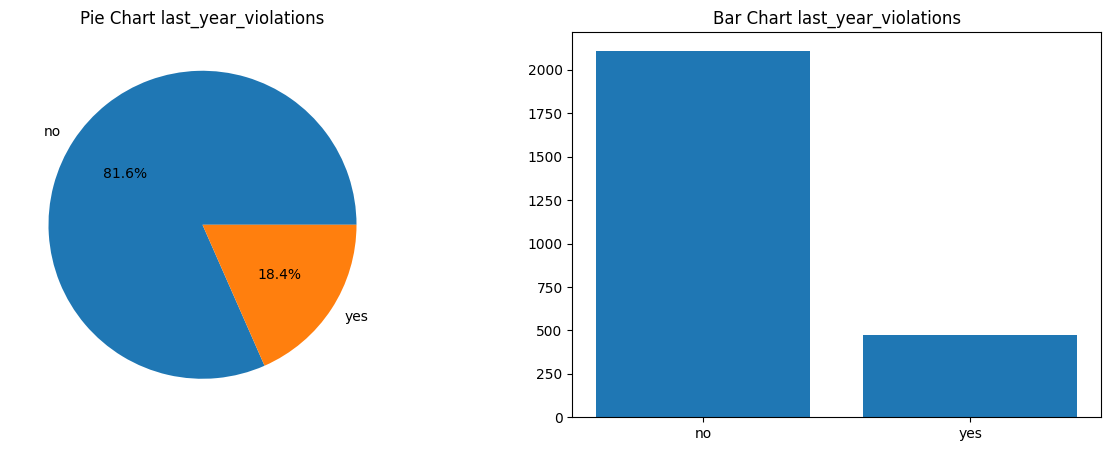

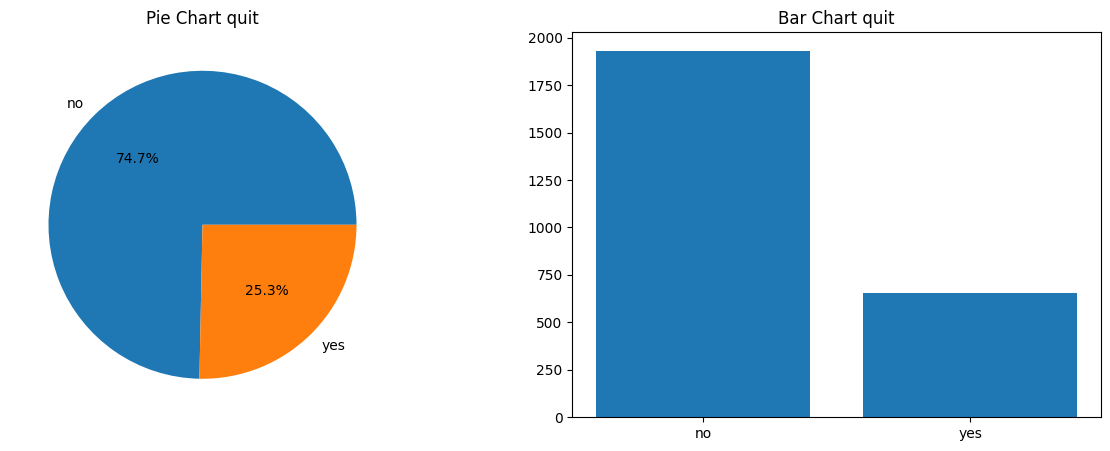

In [59]:
for i in df_train.select_dtypes(include = 'object').columns:
        catgraph(df_train, df_train[i])

Есть дисбаланс классов, уместно использовать ROC-AUC для оценки модели.

### Портрет «уволившегося сотрудника»

Рассмотрим статистику по увольнениям в разрезе фичей

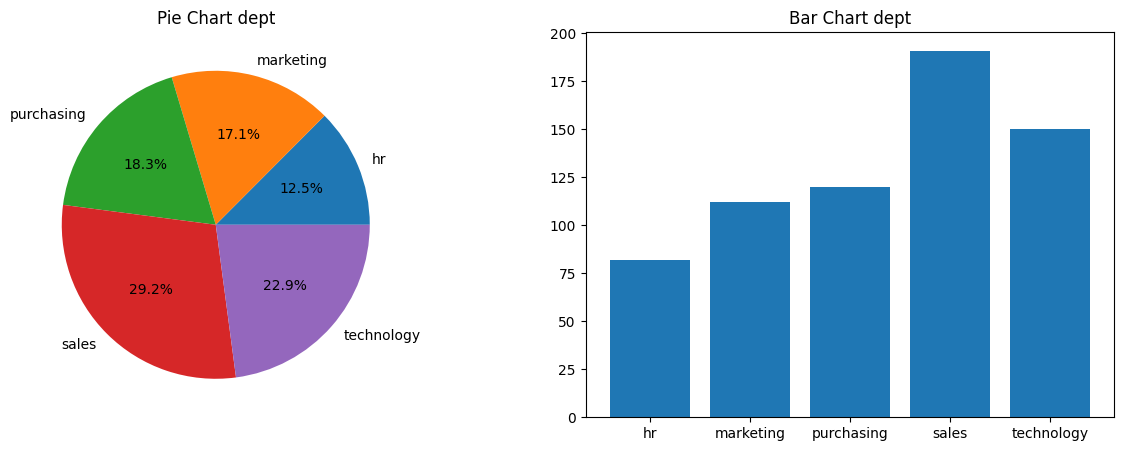

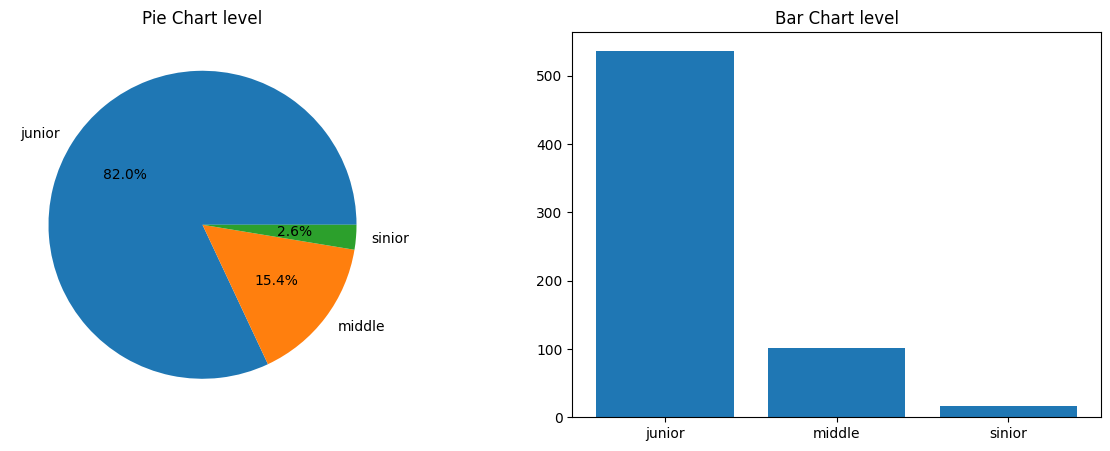

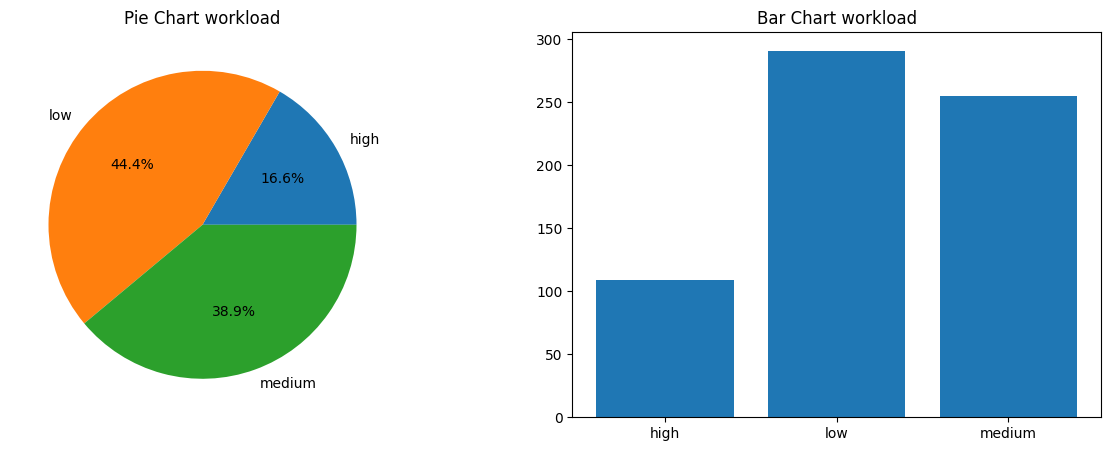

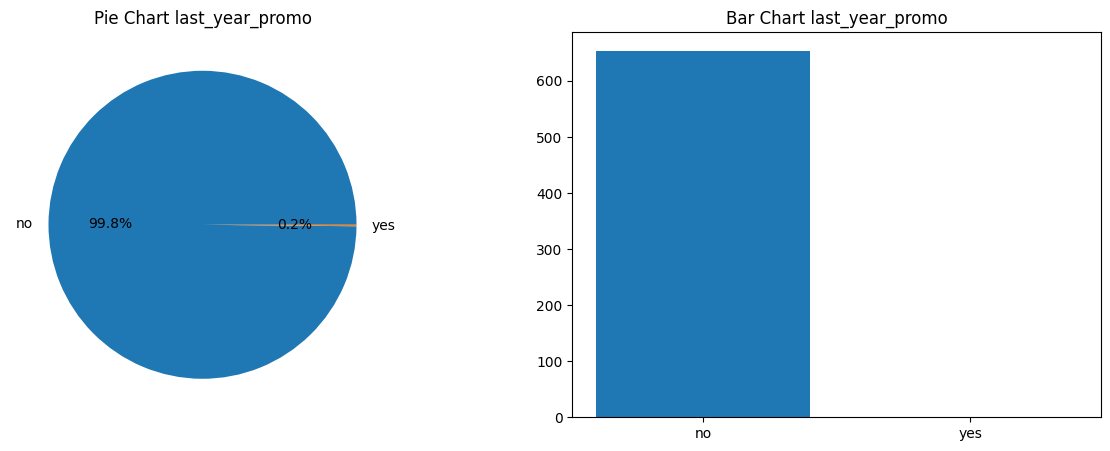

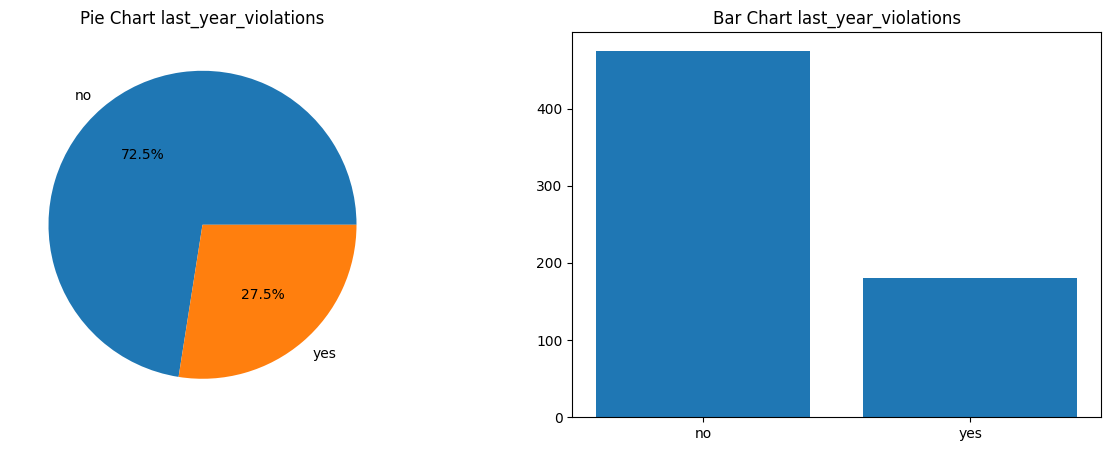

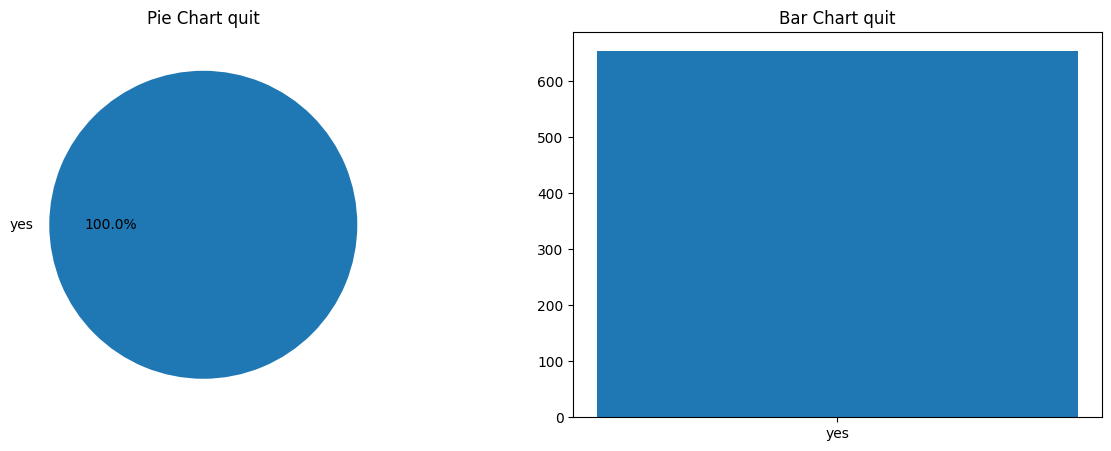

In [60]:
for i in df_train.select_dtypes(include = 'object').columns:
        catgraph(df_train[df_train['quit'] == 'yes'], df_train[i])

Уходят больше всего из отделов 'sales' и 'technology', на что следует обратить внимание. Самое интересное, что уходят в основном младшие позиции с низкой и средней загрузкой, не получавшие повышений за год. Вероятно, причиной ухода становится отсутствие возможностей карьерного роста ввиду нехватки задач. Картина сходится с гипотезой об оттоке джунов, выведенной при корреляционном анализе.

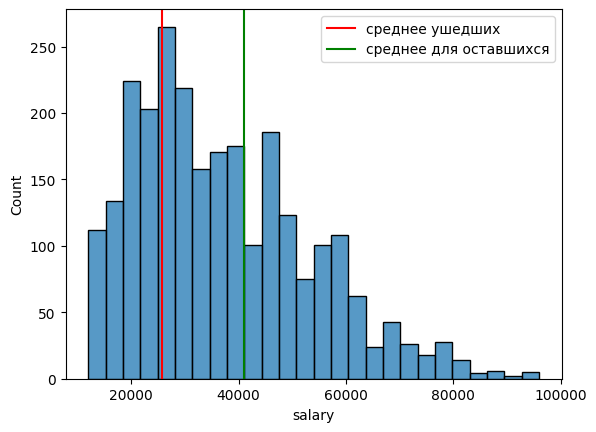

In [61]:
fig = sns.histplot(
    df_train['salary']
    );

fig.axvline(
    df_train[df_train['quit'] == 'yes']['salary'].mean(),
    color='r',
    label = 'среднее ушедших');

fig.axvline(
    df_train[df_train['quit'] == 'no']['salary'].mean(),
    color='g',
    label = 'среднее для оставшихся');

plt.legend()

Зарплаты уволившихся сотрудников в среднем ниже, чем у оставшихся. Важная деталь для понимания мотивов увольнения.

In [62]:
quit_grouped = df_train.groupby('dept')['quit'].value_counts().unstack().fillna(0)
quit_grouped['quit_rate'] = (quit_grouped['yes'] / (quit_grouped['yes'] + quit_grouped['no'])) * 100
quit_grouped['sum'] = quit_grouped['yes'] + quit_grouped['no']
for dept in quit_grouped.index:
    quit_rate = quit_grouped.loc[dept, 'quit_rate']
    total_employees = quit_grouped.loc[dept, 'sum']
    quit_total = quit_grouped.loc[dept, 'yes']

    print(f"Доля увольнений от {total_employees} сотрудников {dept} = {round(quit_rate,1)}%, всего уволилось {quit_total}")

доля увольнений от 348 сотрудников hr = 23.6%, всего уволилось 82
доля увольнений от 423 сотрудников marketing = 26.5%, всего уволилось 112
доля увольнений от 430 сотрудников purchasing = 27.9%, всего уволилось 120
доля увольнений от 805 сотрудников sales = 23.7%, всего уволилось 191
доля увольнений от 581 сотрудников technology = 25.8%, всего уволилось 150


Доля увольнений от 348 сотрудников hr = 23.6%, всего уволилось 82;

Доля увольнений от 423 сотрудников marketing = 26.5%, всего уволилось 112;

Доля увольнений от 430 сотрудников purchasing = 27.9%, всего уволилось 120;

Доля увольнений от 805 сотрудников sales = 23.7%, всего уволилось 191;

Доля увольнений от 581 сотрудников technology = 25.8%, всего уволилось 150;

Как видим, явного перевеса по доле увольнений в разрезе отделов компании не наблюдается.


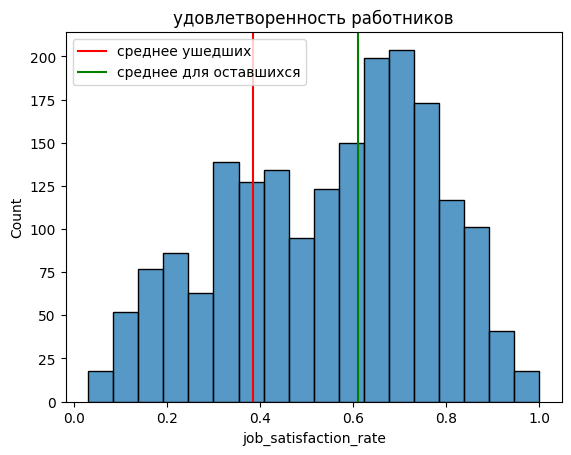

In [63]:
fig = sns.histplot(
    df_test['job_satisfaction_rate']
    );

plt.title('удовлетворенность работников')

fig.axvline(
    df_test[df_test['quit'] == 'yes']['job_satisfaction_rate'].mean(),
    color='r',
    label = 'среднее ушедших');

fig.axvline(
    df_test[df_test['quit'] == 'no']['job_satisfaction_rate'].mean(),
    color='g',
    label = 'среднее для оставшихся');

plt.legend()

Выглядит правдоподобно, чем ниже удволетворённость - тем выше риск ухода.  Признак 'job_satisfaction_rate' будет полезен для модели.

## Корреляционный анализ

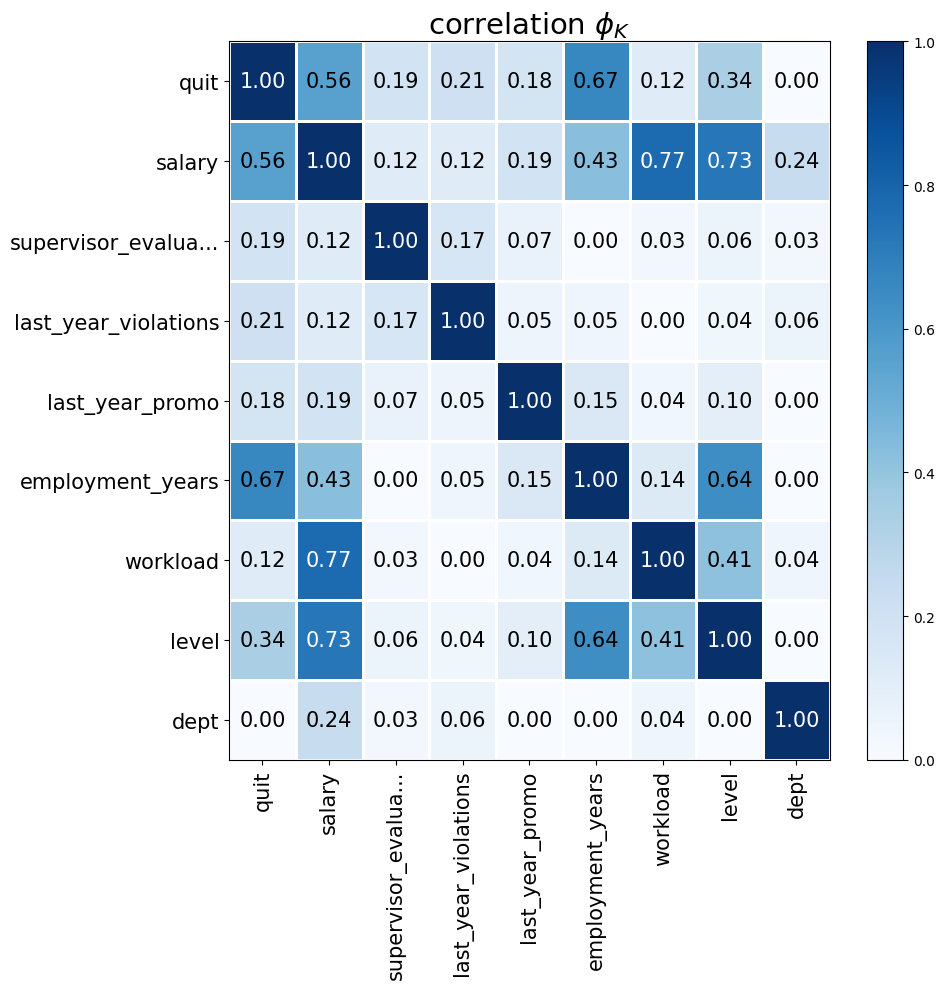

In [64]:
# Матрица phik

interval_cols = df_test.select_dtypes(exclude = 'object').columns
phik_overview = phik_matrix(df_train, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(10, 10)
)

Заметно коррелируют с таргетом признаки salary (рассмотрели выше) и employment_years.

## Добавление нового признака

In [65]:
df_train['job_satisfaction_rate'] = model.predict(df_train.drop('quit', axis = 1))

/tmp/ipython-input-4080242856.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['job_satisfaction_rate'] = model.predict(df_train.drop('quit', axis = 1))


## Подготовка данных для моделирования

In [66]:
X_train = df_train.drop('quit', axis = 1)
y_train = df_train['quit']

In [67]:
ord_cols = ['level','workload']
ohe_cols = ['dept', 'last_year_promo', 'last_year_violations']
num_cols = df_train.select_dtypes(exclude = 'object').columns

In [68]:
ohe_pipe = Pipeline(
[
    ('SimpleImputer_ohe',
    SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('SimpleImputer_2',
    SimpleImputer(missing_values= ' ', strategy='most_frequent')),
    ('ohe',
    OneHotEncoder(drop = 'first', handle_unknown='error'))
]
)
ord_pipe = Pipeline(
[
    ('SimpleImputer_bOE',
    SimpleImputer(missing_values = np.nan, strategy ='most_frequent')),
    ('OE',
    OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = np.nan)),
    ('SimpleImputer_aOE',
    SimpleImputer(missing_values = np.nan, strategy ='most_frequent'))
]
)

preprocessor = ColumnTransformer(
[
    ('ohe', ohe_pipe, ohe_cols),
    ('ord', ord_pipe, ord_cols),
    ('num', StandardScaler(), num_cols)
],
    remainder='passthrough'
)

In [69]:
param_grid = [
    {
        'model' : [KNeighborsClassifier()],
        'model__n_neighbors' : range(1,30),
        'preprocessor__num' : [StandardScaler(),
                           MinMaxScaler(),
                           RobustScaler(),
                           'passthrough']
    },
    {
        'model' : [DecisionTreeClassifier(random_state = RANDOM_STATE)],
        'model__max_depth' : range(1,30),
        'model__min_samples_split' : range(2,30),
        'model__min_samples_leaf' : range(1,30),
        'preprocessor__num' : [StandardScaler(),
                           MinMaxScaler(),
                           RobustScaler(),
                           'passthrough']
    },
    {
        'model' : [LogisticRegression(random_state = RANDOM_STATE)],
        'model__C' : range(1,30),
        'model__solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'preprocessor__num' : [StandardScaler(),
                           MinMaxScaler(),
                           RobustScaler(),
                           'passthrough']
    },
    {
        'model' : [SVC(random_state = RANDOM_STATE, probability= True)],
        'model__kernel' : ['poly', 'rbf', 'sigmoid', 'precomputed'],
        'model__degree' : range(1,4),
        'preprocessor__num' : [StandardScaler(),
                           MinMaxScaler(),
                           RobustScaler(),
                           'passthrough']
    }
]

In [70]:
full_pipe = Pipeline(
[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
]
)

In [71]:
randomized_search = RandomizedSearchCV(
    full_pipe,
    param_distributions=param_grid,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

## Обучение моделей

In [72]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('SimpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('SimpleImputer_2',
                                                                                                SimpleImputer(missing_values=' ',
                                                                                                              strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_...
                                                           'newton-cholesky',
                                                           'sag', 'saga'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'model': [SVC(probability=True,
                                                       random_state=52)],
                                         'model__degree': range(1, 4),
                                         'model__kernel': ['poly', 'rbf',
                                                           'sigmoid',
                                                           'precomputed'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=52, scoring='roc_auc')

In [73]:
clf = randomized_search.best_estimator_
randomized_search.best_score_

np.float64(0.9052417077954047)

In [74]:
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('SimpleImputer_2',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pip...
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('SimpleImputer_aOE',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', RobustScaler(),
                                                  Index(['employment_years', 'supervisor_evaluation', 'salary',
       'job_satisfaction_rate'],
      dtype='object'))])),
                ('model',
                 DecisionTreeClassifier(max_depth=23, min_samples_leaf=22,
                                        min_samples_split=15,
                                        random_state=52))])

In [75]:
roc_auc_score(df_test['quit'], clf.predict_proba(df_test.drop('quit', axis = 1))[:,1])

np.float64(0.927382976697365)

### Вывод

**Лучше всего себя показала модель DecisionTreeClassifier, ROC-AUC ~0.93.**

# Общий вывод

## В процессе работы над проектом были выполнены следующие задачи:

1. **Предсказан уровень удовлетворённости сотрудников(модель регрессии)**

2. **Предсказано увольнение сотрудника из компании(модель классификации)**

## Проект состоял из следющих этапов для каждой задачи:

1. **Загрузка данных**
2. **Предобработка данных**
3. **ИАД**
4. **КАД**
5. **Подготовка данных**
6. **Обучение модели**

## Выводы и предложения:

1. **Портрет увольняющегося сотрудника**: Junior/Middle специалист, имеющий амбиции карьерного роста, однако не получающий достаточно нагрузки, и, как следствие, повышение.
2.  **Статистика отделов по увольнениям**

    **доля увольнений от 348 сотрудников hr = 23.6%, всего уволилось 82**

    **доля увольнений от 423 сотрудников marketing = 26.5%, всего уволилось 112**

    **доля увольнений от 430 сотрудников purchasing = 27.9%, всего уволилось 120**

    **доля увольнений от 805 сотрудников sales = 23.7%, всего уволилось 191**

    **доля увольнений от 581 сотрудников technology = 25.8%, всего уволилось 150**

3. Система оценки удовлетворённости работает: видна явная связь между уходом сотрудника из компании и низкой удовлетворённостью